# Computational Intelligence - Homework 2
## Mohammad Bahrami - 9724133

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
NUM_FOLDS = 3

### Data Handling

#### Reading the Data

In [2]:
columns = ['Date', 'WSR0', 'WSR1', 'WSR2', 'WSR3', 'WSR4', 'WSR5', 'WSR6', 'WSR7', 'WSR8', 'WSR9', 'WSR10', 'WSR11', 'WSR12', 'WSR13', 'WSR14', 'WSR15', 'WSR16', 'WSR17', 'WSR18', 'WSR19', 'WSR20', 'WSR21', 'WSR22', 'WSR23', 'WSR_PK', 'WSR_AV', 'T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T_PK', 'T_AV', 'T85', 'RH85', 'U85', 'V85', 'HT85', 'T70', 'RH70', 'U70', 'V70', 'HT70', 'T50', 'RH50', 'U50', 'V50', 'HT50', 'KI', 'TT', 'SLP', 'SLP_', 'Precp']
dataset = pd.read_csv('Ozone Level Detection.data', names=columns + ['label'])
dataset = dataset.replace('?', np.nan)
dataset = dataset.astype(float, errors='ignore')
dataset

,Date,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,...,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,label
0,1/1/1998,0.8,1.8,2.4,2.1,2.0,2.1,1.5,1.7,1.9,...,0.15,10.67,-1.56,5795.0,-12.10,17.90,10330.0,-55.0,0.00,0.0
1,1/2/1998,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,...,0.48,8.39,3.84,5805.0,14.05,29.00,10275.0,-55.0,0.00,0.0
2,1/3/1998,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,...,0.60,6.94,9.80,5790.0,17.90,41.30,10235.0,-40.0,0.00,0.0
3,1/4/1998,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,...,0.49,8.73,10.54,5775.0,31.15,51.70,10195.0,-40.0,2.08,0.0
4,1/5/1998,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.58,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2531,12/27/2004,0.3,0.4,0.5,0.5,0.2,0.3,0.4,0.4,1.3,...,0.07,7.93,-4.41,5800.0,-25.60,21.80,10295.0,65.0,0.00,0.0
2532,12/28/2004,1.0,1.4,1.1,1.7,1.5,1.7,1.8,1.5,2.1,...,0.04,5.95,-1.14,5845.0,-19.40,19.10,10310.0,15.0,0.00,0.0
2533,12/29/2004,0.8,0.8,1.2,0.9,0.4,0.6,0.8,1.1,1.5,...,0.06,7.80,-0.64,5845.0,-9.60,35.20,10275.0,-35.0,0.00,0.0
2534,12/30/2004,1.3,0.9,1.5,1.2,1.6,1.8,1.1,1.0,1.9,...,0.25,7.72,-0.89,5845.0,-19.60,34.20,10245.0,-30.0,0.05,0.0


#### Normalization

In [3]:
dataset.loc[
    :,
    ~np.isin(dataset.columns, ['Date', 'label'])
] = dataset.loc[
    :,
    ~np.isin(dataset.columns, ['Date', 'label'])
].apply(
    lambda z: (z - z.mean()) / z.std(), axis=1
)

#### Nan Imputation

There are several methods available for replacing the nan values with an actual value. Some of the simpler, more naive methods available are replacing the nans with a constant or replacing them with statistical properties of the same column. For example, replacing the nans in one column with the mean or median of that column.

Some other sophisticated methods involve using the values from one column as well as values from other columns to replace the values in that column. One method to name, is using the K-Nearest Neighbors, KNN, algorithm to impute the missing values. Using KNN, the K-nearest neighbors of the row that has a missing value are found. Then, the mean of the neighbors in the missing column is used to estimate the missing column of that row.

Another method, which we will use in this work, is a variant of MICE. First, we create a simple regressor, then, in an iterative fashion, each data column is set to be the target of that regressor, and the regressor is trained with the other columns of the data. finally, the regressor is used to predict the missing values in the data. The `label` column can be left out or can be used. We will not use the `label` column for imputation in this work. This method can be repeated several times to improve the accuracy of the imputed values.

We will use the `IterativeImputer` combined with a `SVM Regressor` from the scikit-learn library.

In [4]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.svm import SVR

imputable_columns_filter = ~np.isin(dataset.columns, ['Date', 'label'])
regressor = SVR()
imputer = IterativeImputer(estimator=regressor, max_iter=15, initial_strategy='mean', verbose=2)
filled = imputer.fit_transform(dataset.loc[:, imputable_columns_filter])
dataset.loc[:, imputable_columns_filter] = filled

[IterativeImputer] Completing matrix with shape (2536, 72)
[IterativeImputer] Ending imputation round 1/15, elapsed time 0.62
[IterativeImputer] Change: 17.93681040241495, scaled tolerance: 0.007536621665811006 
[IterativeImputer] Ending imputation round 2/15, elapsed time 1.18
[IterativeImputer] Change: 7.989860003192242, scaled tolerance: 0.007536621665811006 
[IterativeImputer] Ending imputation round 3/15, elapsed time 1.77
[IterativeImputer] Change: 13.222354527660597, scaled tolerance: 0.007536621665811006 
[IterativeImputer] Ending imputation round 4/15, elapsed time 2.33
[IterativeImputer] Change: 14.149428746915216, scaled tolerance: 0.007536621665811006 
[IterativeImputer] Ending imputation round 5/15, elapsed time 2.89
[IterativeImputer] Change: 11.870916357594696, scaled tolerance: 0.007536621665811006 
[IterativeImputer] Ending imputation round 6/15, elapsed time 3.41
[IterativeImputer] Change: 11.730013550882097, scaled tolerance: 0.007536621665811006 
[IterativeImputer] 

/home/indirected/VirtualEnvs/torch-cuda102/lib/python3.10/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


#### K-Fold Cross Validation

This Function Returns a list of length `num_folds`. each member of the list is a dictionary with 2 arrays for train and validation respectively. To produce this list, first a random permutation of the indices of the data is created. Then, this permutation is split into `num_folds` arrays. for each fold, one of these split arrays is used to create the validation set and the other splits are used to create the train set.


In [7]:
def k_fold(len_data: int, num_folds: int):
    perm = np.random.permutation(len_data - 1)
    splits = np.array_split(perm, num_folds)
    folds = []
    for split in splits:
        test = split
        train = perm[~np.isin(perm, split)]
        folds.append({
            'train': train,
            'test': test,
        })
    return folds

In [8]:
folds = k_fold(dataset.shape[0], NUM_FOLDS)

#### Balancing the Dataset [OPTIONAL]

In [9]:
dataset['label'].value_counts(normalize=True)

0.0    0.971215
1.0    0.028785
Name: label, dtype: float64

We can see that the portion of negative labels is larger than the portion of positive samples drastically.This causes the model to bias towards the negative side; Hence, we need to balance the dataset by resampling the data. In this work, we will up-sample the negative data points to be equal with the negative samples.

In [10]:
from sklearn.utils import resample
upped_folds = []
for i, fold in enumerate(folds):
    train_df = dataset.loc[fold['train'], :]
    test_df = dataset.loc[fold['test'], :].reset_index(drop=True)

    print(f'{"-"*20} Fold {i + 1} Train Set {"-"*20}')
    print(f'-- Label Portions Before Resampling:')
    print(train_df['label'].value_counts(normalize=True))
    positive_upsampled = resample(train_df.loc[dataset['label'] == 1, :], n_samples=train_df[train_df['label'] == 0].shape[0]//2)
    train_df = pd.concat((
        train_df[train_df['label'] == 0],
        positive_upsampled
    )).sample(frac=1).reset_index(drop=True)
    print(f'-- Label Portions After Resampling:')
    print(train_df['label'].value_counts(normalize=True))

    upped_folds.append({
        'train': train_df,
        'test': test_df
    })


-------------------- Fold 1 Train Set --------------------
-- Label Portions Before Resampling:
0.0    0.969231
1.0    0.030769
Name: label, dtype: float64
-- Label Portions After Resampling:
0.0    0.666667
1.0    0.333333
Name: label, dtype: float64
-------------------- Fold 2 Train Set --------------------
-- Label Portions Before Resampling:
0.0    0.97574
1.0    0.02426
Name: label, dtype: float64
-- Label Portions After Resampling:
0.0    0.666801
1.0    0.333199
Name: label, dtype: float64
-------------------- Fold 3 Train Set --------------------
-- Label Portions Before Resampling:
0.0    0.968639
1.0    0.031361
Name: label, dtype: float64
-- Label Portions After Resampling:
0.0    0.666802
1.0    0.333198
Name: label, dtype: float64


### Logistic Regression

#### Loss Function and Derivatives

In [11]:
def sigmoid(array):
    array = np.array(array)
    return 1 / (1 + np.e ** (-array.astype(np.float128)))


def CrossEntropyLoss(X, Y, Theta, reg_lambda):
    X = np.array(X) #shape: m * (n+1)
    Y = np.array(Y) #shape: m * 1
    Theta = np.array(Theta) #shape: (n+1) * 1
    m = X.shape[0]
    y_hat = sigmoid(X @ Theta) #shape: m * 1
    J = (-1/m * np.sum(Y * np.log(y_hat) + (1 - Y) * np.log(1 - y_hat))) + (reg_lambda/2 * np.sum(Theta**2))
    return J


def CrossEntropyGrad(X, Y, Theta, reg_lambda):
    X = np.array(X) #shape: m * (n+1)
    Y = np.array(Y) #shape: m * 1
    Theta = np.array(Theta) #shape: (n+1) * 1
    m = X.shape[0]
    y_hat = sigmoid(X @ Theta) #shape: m * 1
    grad = (-1/m * (X.T @ (Y - y_hat))) + (reg_lambda * Theta)
    return grad

#### Gradient Descent

In [12]:
def get_Accuracy(X, Y, Theta):
    Y_hat = sigmoid(X @ Theta)
    predictions = np.round(Y_hat)
    return (predictions == Y).sum(), Y.shape[0]


def GradientDescentStep(X, Y, Theta, lr, reg_lambda, cost_grad_fn):
    Theta = np.array(Theta)
    return Theta - lr * cost_grad_fn(X, Y, Theta, reg_lambda)


def GradientDescent(X, Y, Theta_init, lr, reg_lambda, batch_size, iterations, cost_fn, cost_grad_fn, verbose=0, print_every=20):
    Theta = np.array(Theta_init)
    X = np.array(X)
    Y = np.array(Y)
    J_history = []
    correct_history = []
    for i in range(iterations):
        batch_idxs = np.array_split(np.random.permutation(X.shape[0]), batch_size)
        # batch_idxs = np.random.randint(X.shape[0], size=batch_size)
        J = cost_fn(X, Y, Theta, reg_lambda)
        for batch in batch_idxs:
            Theta = GradientDescentStep(X[batch, :], Y[batch], Theta, lr, reg_lambda, cost_grad_fn)
        correct, total = get_Accuracy(X, Y, Theta)
        accuracy = correct / total
        J_history.append(J)
        correct_history.append(correct)
        if verbose != 0:
            if i == 0 or (i+1)%print_every == 0:
                print(f'Iteration: {i+1 if i != 0 else 0} - Average Loss: {J: .4f} - Train Accuracy: {correct / total * 100: .2f}')
    return Theta, np.array(J_history), np.array(correct_history), total

#### Train / Evaluation Loop

In [13]:
def LogisticRegresionLoop(LR = 0.001, LAMBDA = 0.2, EPOCHS = 500, BATCH_SIZE = 32, verbose=1):
    logistic_regression_fold_results = []
    
    # WORKS WITH THE IMBALANCE DATA
    for f, fold in enumerate(folds):
        X_train = dataset.loc[
            fold['train'],
            ~np.isin(dataset.columns, ['Date', 'label'])
        ].to_numpy()
        X_train = np.concatenate((
            np.ones((X_train.shape[0], 1)),
            X_train
        ), axis=1)
        Y_train = dataset.loc[fold['train'], 'label'].to_numpy().reshape((-1, 1))

        X_test = dataset.loc[
            fold['test'],
            ~np.isin(dataset.columns, ['Date', 'label'])
        ].to_numpy()
        X_test = np.concatenate((
            np.ones((X_test.shape[0], 1)),
            X_test
        ), axis=1)
        Y_test = dataset.loc[fold['test'], 'label'].to_numpy().reshape((-1, 1))


    # #### COMMENT THIS BLOCK IF YOU UNCOMMENT THE ABOVE LINES #### #MUST RUN RESAMBLING CELLS#
    # for f, fold in enumerate(upped_folds):
    #     X_train = fold['train'].loc[
    #         :,
    #         ~np.isin(dataset.columns, ['Date', 'label'])
    #     ].to_numpy()
    #     X_train = np.concatenate((
    #         np.ones((X_train.shape[0], 1)),
    #         X_train
    #     ), axis=1)
    #     Y_train = fold['train'].loc[:, 'label'].to_numpy().reshape((-1, 1))

    #     X_test = fold['test'].loc[
    #         :,
    #         ~np.isin(dataset.columns, ['Date', 'label'])
    #     ].to_numpy()
    #     X_test = np.concatenate((
    #         np.ones((X_test.shape[0], 1)),
    #         X_test
    #     ), axis=1)
    #     Y_test = fold['test'].loc[:, 'label'].to_numpy().reshape((-1, 1))
    # #### COMMENT THIS BLOCK IF YOU UNCOMMENT THE ABOVE LINES ####


        Theta_init = np.random.random((X_train.shape[1], 1))
        if verbose:
            print(f'{"="*40} Beginning Fold: {f+1} {"="*40}')
        Theta, J_history, correct_history, total = GradientDescent(
            X_train,
            Y_train,
            Theta_init,
            LR,
            LAMBDA,
            BATCH_SIZE,
            EPOCHS,
            CrossEntropyLoss,
            CrossEntropyGrad,
            verbose=verbose,
            print_every=50
        )

        test_correct, test_total = get_Accuracy(X_test, Y_test, Theta)

        logistic_regression_fold_results.append({
            'initial_train_loss': J_history[0],
            'avg_train_loss': J_history.mean(),
            'final_train_loss': J_history[-1],
            'final_train_accuracy': correct_history[-1] / total,
            'loss_history': J_history,
            'correct_history': correct_history,
            'train_total': total,
            'test_accuracy': test_correct / test_total,
            'test_correct': test_correct,
            'test_total': test_total
        })
        if verbose:
            print(f'\t---- Fold {f + 1} Summary ----')
            print(f'\tInitial Train Loss: {J_history[0]: .4f}')
            print(f'\tAverage Train Loss: {J_history.mean(): .4f}')
            print(f'\tFinal Train Loss: {J_history[-1]: .4f}')
            print(f'\tFinal Train Accuracy: {correct_history[-1] / total * 100: .2f}')
            print(f'\tTest Accuracy: {test_correct / test_total * 100: .2f}')
            print(f'{"="*99}')
    return logistic_regression_fold_results

In [14]:
tuned_results = pd.DataFrame(LogisticRegresionLoop())

======================================== Beginning Fold: 1 ========================================
Iteration: 0 - Average Loss:  2.3464 - Train Accuracy:  96.80
Iteration: 50 - Average Loss:  1.3188 - Train Accuracy:  96.86
Iteration: 100 - Average Loss:  0.7674 - Train Accuracy:  96.92
Iteration: 150 - Average Loss:  0.4781 - Train Accuracy:  96.92
Iteration: 200 - Average Loss:  0.3261 - Train Accuracy:  96.92
Iteration: 250 - Average Loss:  0.2462 - Train Accuracy:  96.92
Iteration: 300 - Average Loss:  0.2042 - Train Accuracy:  96.92
Iteration: 350 - Average Loss:  0.1820 - Train Accuracy:  96.92
Iteration: 400 - Average Loss:  0.1703 - Train Accuracy:  96.92
Iteration: 450 - Average Loss:  0.1642 - Train Accuracy:  96.92
Iteration: 500 - Average Loss:  0.1609 - Train Accuracy:  96.92
	---- Fold 1 Summary ----
	Initial Train Loss:  2.3464
	Average Train Loss:  0.4983
	Final Train Loss:  0.1609
	Final Train Accuracy:  96.92
	Test Accuracy:  97.51
===================================

#### Results

In [15]:
for l in [0, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]:
    result_df = pd.DataFrame(LogisticRegresionLoop(LAMBDA=l, verbose=0))
    print(f'lambda: {l}')
    print(f'\tTrain Accuracy: [Mean:{result_df["final_train_accuracy"].mean()*100: .2f}, Std:{result_df["final_train_accuracy"].std()*100: .2f}]')
    print(f'\tTest Accuracy: [Mean:{result_df["test_accuracy"].mean()*100: .2f}, Std:{result_df["test_accuracy"].std()*100: .2f}]')
    print('-'*80)

lambda: 0
	Train Accuracy: [Mean: 97.06, Std: 0.44]
	Test Accuracy: [Mean: 97.04, Std: 0.92]
--------------------------------------------------------------------------------
lambda: 0.01
	Train Accuracy: [Mean: 97.06, Std: 0.44]
	Test Accuracy: [Mean: 97.04, Std: 0.92]
--------------------------------------------------------------------------------
lambda: 0.03
	Train Accuracy: [Mean: 97.06, Std: 0.45]
	Test Accuracy: [Mean: 97.04, Std: 0.92]
--------------------------------------------------------------------------------
lambda: 0.1
	Train Accuracy: [Mean: 97.12, Std: 0.39]
	Test Accuracy: [Mean: 97.12, Std: 0.79]
--------------------------------------------------------------------------------
lambda: 0.3
	Train Accuracy: [Mean: 97.12, Std: 0.39]
	Test Accuracy: [Mean: 97.12, Std: 0.79]
--------------------------------------------------------------------------------
lambda: 1
	Train Accuracy: [Mean: 97.12, Std: 0.39]
	Test Accuracy: [Mean: 97.12, Std: 0.79]
---------------------------

We can see that for small values of the regularization parameter, `lambda`, the model is overfitting on the train set(sometimes not! because this is a simple linear model with limited power.), as the train accuracy is higher than the test accuracy. Increasing this value to around $0.3$ gives the best training and test accuracy. Further increase of the regularization parameter will cause the model to underfit as we can see for the values above $0.1$, the accuracies are decreasing constantly.

The Final tuned model's summary in each fold as well as the overall of all folds is shown below. The loss and train accuracy history of each epoch is depicted in the figures below the summary.

In [16]:
print('---- Tuned Model Summary ----')
for f, row in tuned_results.iterrows():
    print(f'\t -- Fold: {f+1} --')
    print(f'\tInitial Loss: {row["initial_train_loss"]: .4f}')
    print(f'\tFinal Loss: {row["final_train_loss"]: .4f}')
    print(f'\tTrain Accuracy: {row["final_train_accuracy"]*100: .2f}')
    print(f'\tTest Accuracy: {row["test_accuracy"]*100: .2f}')

print(f'-- Overall --')
print(f'Average Initial Loss: {tuned_results["initial_train_loss"].mean(): .4f}')
print(f'Average Final Loss: {tuned_results["final_train_loss"].mean(): .4f}')
print(f'Average Train Accuracy: {tuned_results["final_train_accuracy"].mean()*100: .2f}')
print(f'Std of Train Accuracy: {tuned_results["final_train_accuracy"].std()*100: .2f}')
print(f'Average Test Accuracy: {tuned_results["test_accuracy"].mean()*100: .2f}')
print(f'Std of Test Accuracy: {tuned_results["test_accuracy"].std()*100: .2f}')

---- Tuned Model Summary ----
	 -- Fold: 1 --
	Initial Loss:  2.3464
	Final Loss:  0.1609
	Train Accuracy:  96.92
	Test Accuracy:  97.51
	 -- Fold: 2 --
	Initial Loss:  3.5284
	Final Loss:  0.1407
	Train Accuracy:  97.57
	Test Accuracy:  96.21
	 -- Fold: 3 --
	Initial Loss:  4.1260
	Final Loss:  0.1642
	Train Accuracy:  96.86
	Test Accuracy:  97.63
-- Overall --
Average Initial Loss:  3.3336
Average Final Loss:  0.1553
Average Train Accuracy:  97.12
Std of Train Accuracy:  0.39
Average Test Accuracy:  97.12
Std of Test Accuracy:  0.79


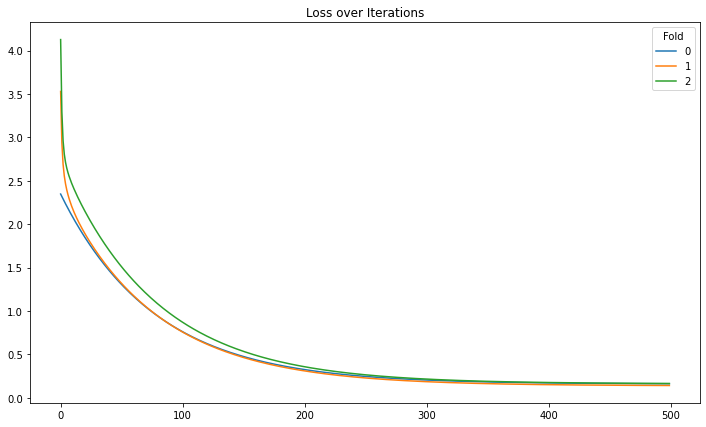

In [17]:
fig, ax = plt.subplots()
for f, row in tuned_results.iterrows():
    ax.plot(row['loss_history'], label=f)
ax.legend(title='Fold')
ax.set_title('Loss over Iterations')
fig.set_size_inches((12, 7))

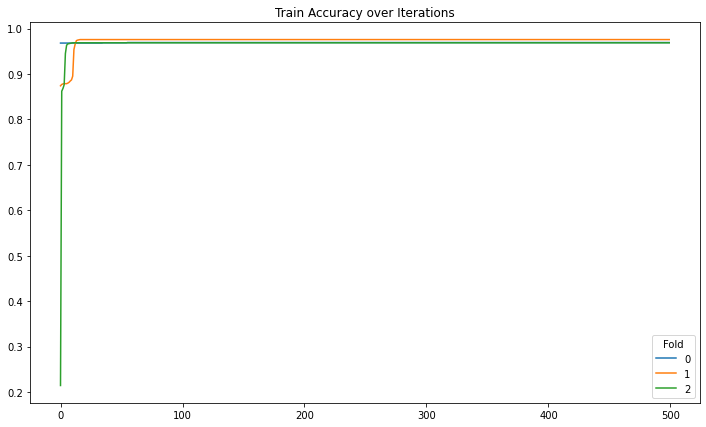

In [18]:
fig, ax = plt.subplots()
for f, row in tuned_results.iterrows():
    ax.plot(row['correct_history'] / row['train_total'], label=f)
ax.legend(title='Fold')
ax.set_title('Train Accuracy over Iterations')
fig.set_size_inches((12, 7))

### Neural Network

#### Model Class

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, fc_dims: list):
        super(MLP, self).__init__()

        self.fc_layers = nn.ModuleList([
            nn.Linear(fc_dims[i], fc_dims[i+1]) for i in range(len(fc_dims[:-1]))
        ])
        self.classifier = nn.Sigmoid()
    
    def forward(self, batch):
        x = batch
        for layer in self.fc_layers[:-1]:
            x = layer(x)
            x = F.relu(x)
        x = self.fc_layers[-1](x)
        return self.classifier(x)

#### Train Evaluation Loop

In [21]:
def train(model, batch_loader, criterion, optimizer, class_weights=None):
    # if class_weights is None:
    #     class_weights = []
    t_loss = 0
    t_correct = 0
    t_total = 0
    for batch_idx, (batch_x, batch_y) in enumerate(batch_loader):
        model.train()
        optimizer.zero_grad()
        out = model(batch_x)
        loss = criterion(out, batch_y)
        loss.backward()
        optimizer.step()

        prediction = torch.round(out.detach())
        correct = (prediction == batch_y).sum()
        total = batch_y.shape[0]

        t_loss += loss.item()
        t_correct += correct.item()
        t_total += total
    return t_loss, t_correct, t_total


@torch.no_grad()
def evaluation(model, x_test, y_test):
    model.eval()
    out = model(x_test)
    prediction = torch.round(out.detach())
    correct = (prediction == y_test).sum()
    total = y_test.shape[0]
    model.train()
    return correct.item(), total


def MLPLoop(LR = 0.001, LAMBDA = 0.3, EPOCHS = 200, BATCH_SIZE = 32, FC_HIDDEN_DIMS = [32, 8], verbose = 1):
    mlp_fold_results = []
    
    # WORKS WITH THE IMBALANCE DATA
    for f, fold in enumerate(folds):
        X_train = torch.tensor(dataset.loc[
            fold['train'],
            ~np.isin(dataset.columns, ['Date', 'label'])
        ].to_numpy(), dtype=torch.float)
        Y_train = torch.tensor(dataset.loc[fold['train'], 'label'].to_numpy().reshape((-1, 1)), dtype=torch.float)

        negative_weight = 1
        positive_weight = ((Y_train == 0).sum() / (Y_train == 1).sum()).item()

        X_test = torch.tensor(dataset.loc[
            fold['test'],
            ~np.isin(dataset.columns, ['Date', 'label'])
        ].to_numpy(), dtype=torch.float)
        Y_test = torch.tensor(dataset.loc[fold['test'], 'label'].to_numpy().reshape((-1, 1)), dtype=torch.float)
        

    # #### COMMENT THIS BLOCK IF YOU UNCOMMENT THE ABOVE LINES #### #MUST RUN RESAMPLE PART#
    # for f, fold in enumerate(upped_folds):
    #     X_train = torch.tensor(fold['train'].loc[
    #         :,
    #         ~np.isin(dataset.columns, ['Date', 'label'])
    #     ].to_numpy(), dtype=torch.float)
        
    #     Y_train = torch.tensor(fold['train'].loc[:, 'label'].to_numpy().reshape((-1, 1)), dtype=torch.float)

    #     X_test = torch.tensor(fold['test'].loc[
    #         :,
    #         ~np.isin(dataset.columns, ['Date', 'label'])
    #     ].to_numpy(), dtype=torch.float)
        
    #     Y_test = torch.tensor(fold['test'].loc[:, 'label'].to_numpy().reshape((-1, 1)), dtype=torch.float)
    # #### COMMENT THIS BLOCK IF YOU UNCOMMENT THE ABOVE LINES ####



        if verbose:
            print(f'{"="*40} Beginning Fold: {f+1} {"="*40}')
        ds = torch.utils.data.TensorDataset(X_train, Y_train)
        batch_loader = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True) 
        
        model = MLP(fc_dims= [X_train.shape[1]] + FC_HIDDEN_DIMS + [1])
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=LAMBDA)

        loss_history = []
        correct_history = []
        t_total = 0
        for epoch in range(EPOCHS):
            loss, correct, total = train(model, batch_loader, criterion, optimizer)
            loss_history.append(loss / total)
            correct_history.append(correct)
            t_total = total
            if verbose:
                if (epoch+1) % 50 == 0 or epoch == 0:
                    print(f'Epoch: {epoch + 1 if epoch != 0 else 0} - Loss: {loss / total: .4f} - Train Accuracy: {correct / total * 100: .2f}')
        
        test_correct, test_total = evaluation(model, X_test, Y_test)

        mlp_fold_results.append({
            'initial_train_loss': loss_history[0],
            'avg_train_loss': np.mean(loss_history),
            'final_train_loss': loss_history[-1],
            'final_train_accuracy': correct_history[-1] / total,
            'loss_history': loss_history,
            'correct_history': correct_history,
            'train_total': total,
            'test_accuracy': test_correct / test_total,
            'test_correct': test_correct,
            'test_total': test_total
        })
        if verbose:
            print(f'\t---- Fold {f + 1} Summary ----')
            print(f'\tInitial Train Loss: {loss_history[0]: .4f}')
            print(f'\tAverage Train Loss: {np.mean(loss_history): .4f}')
            print(f'\tFinal Train Loss: {loss_history[-1]: .4f}')
            print(f'\tFinal Train Accuracy: {correct_history[-1] / total * 100: .2f}')
            print(f'\tTest Accuracy: {test_correct / test_total * 100: .2f}')
            print(f'{"="*99}')
    return mlp_fold_results

In [22]:
tuned_mlp_results = pd.DataFrame(MLPLoop())

======================================== Beginning Fold: 1 ========================================
Epoch: 0 - Loss:  0.0235 - Train Accuracy:  7.10
Epoch: 50 - Loss:  0.0052 - Train Accuracy:  96.92
Epoch: 100 - Loss:  0.0052 - Train Accuracy:  96.92
Epoch: 150 - Loss:  0.0053 - Train Accuracy:  96.92
Epoch: 200 - Loss:  0.0053 - Train Accuracy:  96.92
	---- Fold 1 Summary ----
	Initial Train Loss:  0.0235
	Average Train Loss:  0.0055
	Final Train Loss:  0.0053
	Final Train Accuracy:  96.92
	Test Accuracy:  97.51
======================================== Beginning Fold: 2 ========================================
Epoch: 0 - Loss:  0.0201 - Train Accuracy:  61.24
Epoch: 50 - Loss:  0.0046 - Train Accuracy:  97.57
Epoch: 100 - Loss:  0.0046 - Train Accuracy:  97.57
Epoch: 150 - Loss:  0.0047 - Train Accuracy:  97.57
Epoch: 200 - Loss:  0.0046 - Train Accuracy:  97.57
	---- Fold 2 Summary ----
	Initial Train Loss:  0.0201
	Average Train Loss:  0.0048
	Final Train Loss:  0.0046
	Final Train

#### Results

In [26]:
for l in [0, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]:
    result_df = pd.DataFrame(MLPLoop(LAMBDA=l, verbose=0))
    print(f'lambda: {l}')
    print(f'\tTrain Accuracy: [Mean:{result_df["final_train_accuracy"].mean()*100: .2f}, Std:{result_df["final_train_accuracy"].std()*100: .2f}]')
    print(f'\tTest Accuracy: [Mean:{result_df["test_accuracy"].mean()*100: .2f}, Std:{result_df["test_accuracy"].std()*100: .2f}]')
    print('-'*80)

lambda: 0
	Train Accuracy: [Mean: 97.12, Std: 0.39]
	Test Accuracy: [Mean: 97.12, Std: 0.79]
--------------------------------------------------------------------------------
lambda: 0.01
	Train Accuracy: [Mean: 97.12, Std: 0.39]
	Test Accuracy: [Mean: 97.12, Std: 0.79]
--------------------------------------------------------------------------------
lambda: 0.03
	Train Accuracy: [Mean: 97.12, Std: 0.39]
	Test Accuracy: [Mean: 97.12, Std: 0.79]
--------------------------------------------------------------------------------
lambda: 0.1
	Train Accuracy: [Mean: 97.12, Std: 0.39]
	Test Accuracy: [Mean: 97.12, Std: 0.79]
--------------------------------------------------------------------------------
lambda: 0.3
	Train Accuracy: [Mean: 97.12, Std: 0.39]
	Test Accuracy: [Mean: 97.12, Std: 0.79]
--------------------------------------------------------------------------------
lambda: 1
	Train Accuracy: [Mean: 97.12, Std: 0.39]
	Test Accuracy: [Mean: 97.12, Std: 0.79]
---------------------------

In [27]:
print('---- Tuned Model Summary ----')
for f, row in tuned_mlp_results.iterrows():
    print(f'\t -- Fold: {f+1} --')
    print(f'\tInitial Loss: {row["initial_train_loss"]: .4f}')
    print(f'\tFinal Loss: {row["final_train_loss"]: .4f}')
    print(f'\tTrain Accuracy: {row["final_train_accuracy"]*100: .2f}')
    print(f'\tTest Accuracy: {row["test_accuracy"]*100: .2f}')

print(f'-- Overall --')
print(f'Average Initial Loss: {tuned_results["initial_train_loss"].mean(): .4f}')
print(f'Average Final Loss: {tuned_results["final_train_loss"].mean(): .4f}')
print(f'Average Train Accuracy: {tuned_results["final_train_accuracy"].mean()*100: .2f}')
print(f'Std of Train Accuracy: {tuned_results["final_train_accuracy"].std()*100: .2f}')
print(f'Average Test Accuracy: {tuned_results["test_accuracy"].mean()*100: .2f}')
print(f'Std of Test Accuracy: {tuned_results["test_accuracy"].std()*100: .2f}')

---- Tuned Model Summary ----
	 -- Fold: 1 --
	Initial Loss:  0.0235
	Final Loss:  0.0053
	Train Accuracy:  96.92
	Test Accuracy:  97.51
	 -- Fold: 2 --
	Initial Loss:  0.0201
	Final Loss:  0.0046
	Train Accuracy:  97.57
	Test Accuracy:  96.21
	 -- Fold: 3 --
	Initial Loss:  0.0154
	Final Loss:  0.0054
	Train Accuracy:  96.86
	Test Accuracy:  97.63
-- Overall --
Average Initial Loss:  3.3336
Average Final Loss:  0.1553
Average Train Accuracy:  97.12
Std of Train Accuracy:  0.39
Average Test Accuracy:  97.12
Std of Test Accuracy:  0.79


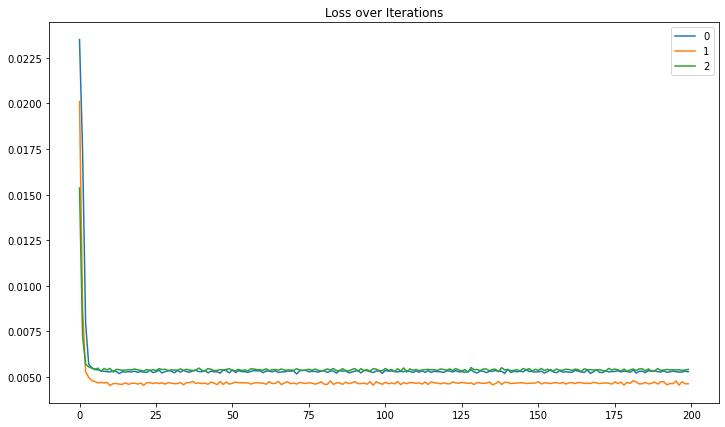

In [28]:
fig, ax = plt.subplots()
for f, row in tuned_mlp_results.iterrows():
    ax.plot(row['loss_history'], label=f)
ax.legend()
ax.set_title('Loss over Iterations')
fig.set_size_inches((12, 7))

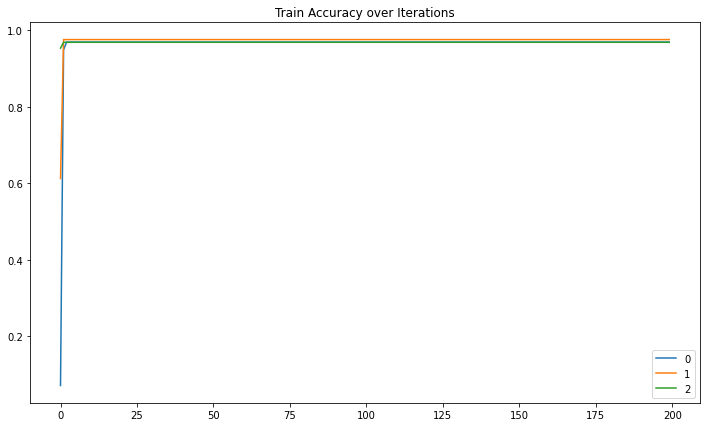

In [29]:
fig, ax = plt.subplots()
for f, row in tuned_mlp_results.iterrows():
    ax.plot(np.array(row['correct_history']) / row['train_total'], label=f)
ax.legend()
ax.set_title('Train Accuracy over Iterations')
fig.set_size_inches((12, 7))